# Creating Terrarium Masks for Gaussian Splatting Pipeline

This notebook demonstrates how to create masks for the ant terrarium video (2025-11-16) to isolate the terrarium from the background for gaussian splatting.

## Workflow Overview

1. **Setup and Load Data** - Load the preprocessed ants video
2. **Test Segmentation** - Test MobileSAM on sample frames
3. **Create Foreground Masks** - Segment terrarium from background
4. **Multi-View Association** - Track masks across video frames
5. **Integrate with Gaussian Splatting** - Train splats with masks
6. **Visualize Results** - View masked 3D reconstruction

## 1. Setup and Imports

In [4]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from typing import List, Dict
from collab_splats.utils.segmentation import Segmentation
from collab_splats.utils.grouping import GroupingClassifier, GroupingConfig
from collab_splats.wrapper import Splatter

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load Ants Video Data

In [5]:
# Paths for ants video
VIDEO_PATH = Path("/workspace/fieldwork-data/ants/2025-11-16/SplatsSD/GH010210.MP4")
DATA_PATH = Path("/workspace/fieldwork-data/ants/2025-11-16/environment/GH010210")
FRAMES_PATH = DATA_PATH / "preproc/images"

# Check paths exist
print(f"Video exists: {VIDEO_PATH.exists()}")
print(f"Frames path exists: {FRAMES_PATH.exists()}")

# Count frames
if FRAMES_PATH.exists():
    frame_files = sorted(list(FRAMES_PATH.glob("frame_*.png")))
    print(f"Number of extracted frames: {len(frame_files)}")
else:
    frame_files = []
    print("No frames found - will need to run preprocessing")

Video exists: True
Frames path exists: True
Number of extracted frames: 599


## 3. Visualize Sample Frames

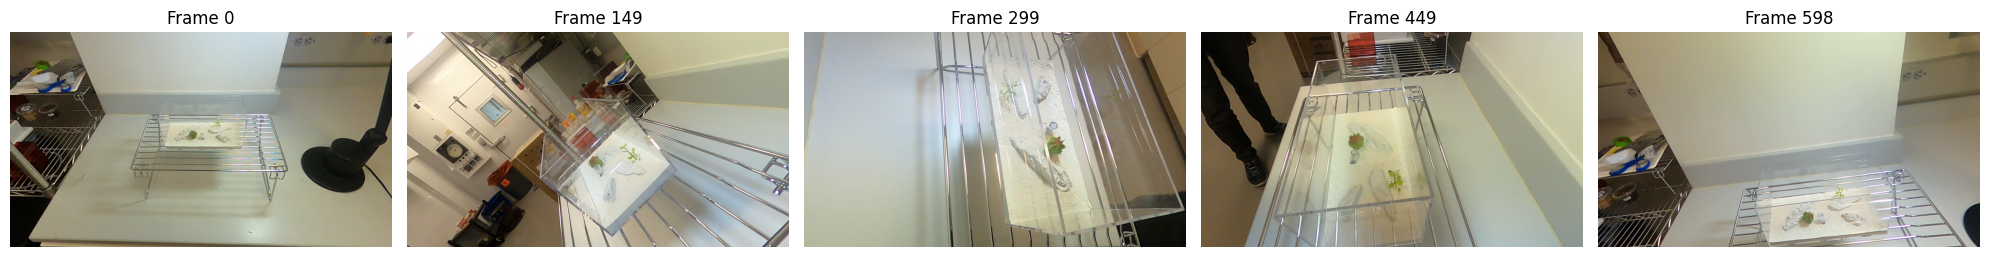

In [6]:
# Load and display sample frames from different parts of the video
sample_indices = [0, len(frame_files)//4, len(frame_files)//2, 3*len(frame_files)//4, -1]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, idx in zip(axes, sample_indices):
    if frame_files:
        img = Image.open(frame_files[idx])
        ax.imshow(img)
        ax.set_title(f"Frame {idx if idx >= 0 else len(frame_files) + idx}")
        ax.axis('off')
plt.tight_layout()
plt.show()

## 4. Initialize Segmentation Model (MobileSAMv2)

We'll use MobileSAMv2 for automatic segmentation. This model can:
- **Auto-segment**: Automatically detect and segment all objects
- **Object-segment**: Detect objects with bounding boxes first, then segment

In [9]:
segmenter = Segmentation(
    backend='mobilesamv2',
    strategy='auto',  # Options: 'auto' or 'object'
    device=device
)
print("Segmentation model loaded successfully")

Using cache found in /workspace/models/hub/RogerQi_MobileSAMV2_main


checkpoint_load_scucess
cuda:0
Segmentation model loaded successfully


## 5. Test Segmentation on Sample Frame

In [10]:
# Load a middle frame for testing
test_frame_idx = len(frame_files) // 2
test_image_path = frame_files[test_frame_idx]
test_image = np.array(Image.open(test_image_path))

print(f"Testing on frame: {test_image_path.name}")
print(f"Image shape: {test_image.shape}")

Testing on frame: frame_00300.png
Image shape: (1080, 1920, 3)


### 5a. Auto Segmentation (All Objects)

In [ ]:
segmenter?

Type:        Segmentation
String form: <collab_splats.utils.segmentation.Segmentation object at 0x7f7b1d19fdc0>
File:        /workspace/collab-splats/collab_splats/utils/segmentation.py
Docstring:   <no docstring>

In [33]:
# Run auto segmentation
masks, mask_info = segmenter.segment(test_image)

print(f"Number of masks detected: {len(mask_info)}")
print("\nMask details:")
# for i, mask_info in enumerate(mask_info[:5]):  # Show first 5
#     mask = mask_info['segmentation']
#     area = mask.sum()
#     print(f"  Mask {i}: area={area} pixels, bbox={mask_info.get('bbox', 'N/A')}")

Number of masks detected: 34

Mask details:


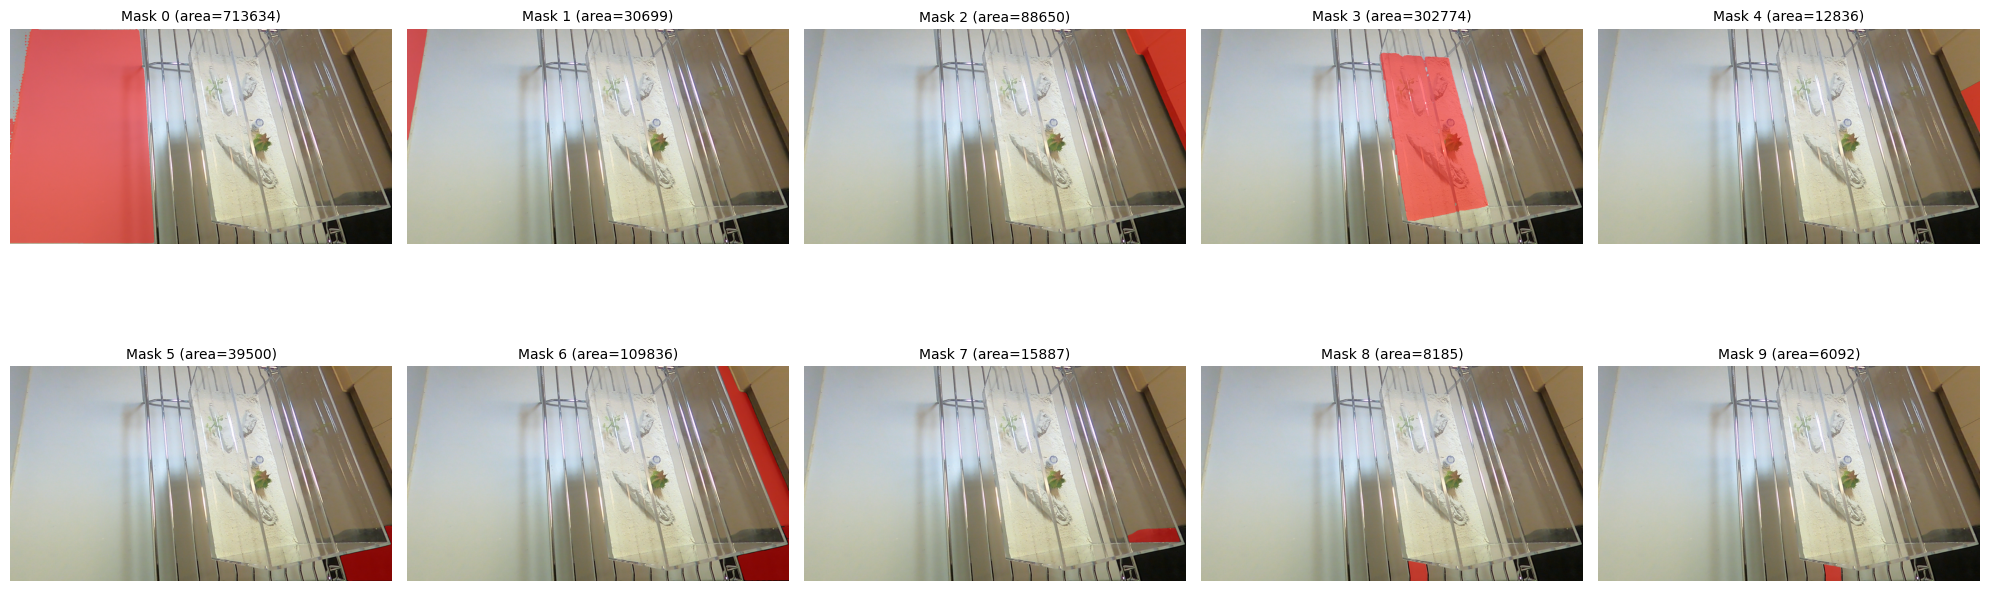

In [35]:
# Visualize all detected masks
def visualize_masks(image, masks, max_masks=10):
    """Visualize segmentation masks overlaid on image"""
    n_masks = min(len(masks), max_masks)
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i in range(n_masks):
        mask = masks[i]['segmentation']
        
        # Create overlay
        overlay = image.copy()
        overlay[mask > 0] = overlay[mask > 0] * 0.5 + np.array([255, 0, 0]) * 0.5
        
        axes[i].imshow(overlay.astype(np.uint8))
        axes[i].set_title(f"Mask {i} (area={mask.sum()})", fontsize=10)
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(n_masks, 10):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_masks(test_image, mask_info)

### 5b. Create Combined Foreground Mask

For gaussian splatting, we want to mask out the BACKGROUND and keep only the terrarium. We'll combine the largest masks to create a foreground mask.

In [ ]:
def create_terrarium_mask(masks, image_shape, min_area_ratio=0.05):
    """
    Create a binary mask for the terrarium by combining large foreground objects.
    
    Args:
        masks: List of mask dictionaries from segmentation
        image_shape: Shape of the image (H, W, C)
        min_area_ratio: Minimum area as fraction of image to include (filters small objects)
    
    Returns:
        Binary mask where 1 = foreground (terrarium), 0 = background
    """
    h, w = image_shape[:2]
    total_pixels = h * w
    
    # Sort masks by area (largest first)
    sorted_masks = sorted(masks, key=lambda x: x['segmentation'].sum(), reverse=True)
    
    # Combine masks that are large enough
    combined_mask = np.zeros((h, w), dtype=bool)
    included_masks = []
    
    for mask_info in sorted_masks:
        mask = mask_info['segmentation']
        area_ratio = mask.sum() / total_pixels
        
        if area_ratio >= min_area_ratio:
            combined_mask = combined_mask | mask
            included_masks.append(mask_info)
    
    print(f"Included {len(included_masks)} masks out of {len(masks)}")
    for i, mask_info in enumerate(included_masks):
        area = mask_info['segmentation'].sum()
        print(f"  Mask {i}: {area} pixels ({area/total_pixels*100:.1f}% of image)")
    
    return combined_mask.astype(np.uint8)

# Create terrarium mask
terrarium_mask = create_terrarium_mask(auto_masks, test_image.shape, min_area_ratio=0.05)

In [ ]:
# Visualize the terrarium mask
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(test_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Mask
axes[1].imshow(terrarium_mask, cmap='gray')
axes[1].set_title('Terrarium Mask (White=Keep, Black=Remove)')
axes[1].axis('off')

# Masked result
masked_image = test_image.copy()
masked_image[terrarium_mask == 0] = 0  # Set background to black
axes[2].imshow(masked_image)
axes[2].set_title('Masked Result')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 6. Process All Frames (Create Masks for Entire Video)

Now we'll create masks for all frames in the video. This can take some time depending on the number of frames.

In [ ]:
# Create output directory for masks
MASKS_OUTPUT_DIR = DATA_PATH / "masks"
MASKS_OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print(f"Masks will be saved to: {MASKS_OUTPUT_DIR}")

In [ ]:
def process_all_frames(frame_files, segmenter, output_dir, 
                      min_area_ratio=0.05, sample_every=1):
    """
    Process all frames and generate terrarium masks.
    
    Args:
        frame_files: List of frame file paths
        segmenter: Segmentation object
        output_dir: Directory to save masks
        min_area_ratio: Minimum area ratio for mask filtering
        sample_every: Process every Nth frame (1 = all frames)
    """
    from tqdm.auto import tqdm
    
    processed_frames = frame_files[::sample_every]
    
    for frame_path in tqdm(processed_frames, desc="Processing frames"):
        # Load image
        image = np.array(Image.open(frame_path))
        
        # Segment
        masks = segmenter.auto_segment_image(image)
        
        # Create terrarium mask
        terrarium_mask = create_terrarium_mask(masks, image.shape, min_area_ratio)
        
        # Save mask
        mask_filename = frame_path.stem + "_mask.png"
        mask_path = output_dir / mask_filename
        Image.fromarray(terrarium_mask * 255).save(mask_path)
    
    print(f"\nProcessed {len(processed_frames)} frames")
    print(f"Masks saved to: {output_dir}")

# Process frames (start with every 10th frame to test)
# Change sample_every=1 to process ALL frames
print("Processing subset of frames (every 10th) for testing...")
print("Set sample_every=1 to process all frames.\n")

process_all_frames(
    frame_files=frame_files,
    segmenter=segmenter,
    output_dir=MASKS_OUTPUT_DIR,
    min_area_ratio=0.05,
    sample_every=10  # Process every 10th frame for testing
)

## 7. Visualize Masks Across Time

Let's check that masks are consistent across frames.

In [ ]:
# Load and visualize masks from different time points
mask_files = sorted(list(MASKS_OUTPUT_DIR.glob("*_mask.png")))

if len(mask_files) > 0:
    sample_mask_indices = [0, len(mask_files)//4, len(mask_files)//2, 
                          3*len(mask_files)//4, -1]
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    
    for col, idx in enumerate(sample_mask_indices):
        mask_path = mask_files[idx]
        
        # Get corresponding frame
        frame_name = mask_path.stem.replace('_mask', '') + '.png'
        frame_path = FRAMES_PATH / frame_name
        
        if frame_path.exists():
            frame = np.array(Image.open(frame_path))
            mask = np.array(Image.open(mask_path))
            
            # Original frame
            axes[0, col].imshow(frame)
            axes[0, col].set_title(f"Frame {frame_name}")
            axes[0, col].axis('off')
            
            # Masked frame
            masked_frame = frame.copy()
            masked_frame[mask == 0] = 0
            axes[1, col].imshow(masked_frame)
            axes[1, col].set_title(f"Masked")
            axes[1, col].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No masks found. Run the processing step first.")

## 8. Integration with Gaussian Splatting Pipeline

Now let's integrate these masks into the gaussian splatting workflow using the Splatter wrapper.

### 8a. Option 1: Using Splatter Wrapper (High-level API)

In [ ]:
# Initialize Splatter for ants video
splatter_config = {
    "file_path": str(VIDEO_PATH),
    "method": "rade-features",  # Use feature-based gaussian splatting
    "frame_proportion": 0.25,
    "min_frames": 300,
    "max_frames": 600,
    "dataset_name": "ants_2025-11-16_GH010210",
    "preproc_data_path": str(DATA_PATH / "preproc"),
}

splatter = Splatter(config=splatter_config)
print("Splatter initialized successfully")

In [ ]:
# Check if preprocessing already done
if (DATA_PATH / "preproc/colmap").exists():
    print("Preprocessing already complete!")
else:
    print("Running preprocessing (frame extraction + COLMAP)...")
    splatter.preprocess()
    print("Preprocessing complete!")

In [ ]:
# Train Gaussian Splatting model
# This will train the model WITHOUT masks first
print("Training Gaussian Splatting model...")
print("This may take 20-30 minutes depending on GPU.\n")

# Uncomment to run training
# splatter.extract_features(
#     max_num_iterations=30000,
#     steps_per_eval_image=500,
#     steps_per_save=5000
# )

### 8b. Option 2: Using GroupingClassifier for Multi-View Mask Association

The GroupingClassifier provides advanced mask tracking across views, which is useful for understanding which gaussians belong to which objects.

In [ ]:
# Setup grouping configuration
grouping_config = GroupingConfig(
    segmentation_backend='mobilesamv2',
    segmentation_strategy='auto',
    front_percentage=0.2,  # Only consider front 20% of gaussians for mask assignment
    iou_threshold=0.1,     # IoU threshold for cross-view association
    num_patches=32,        # Number of patches for memory bank
    identity_dim=13,       # Dimension of identity embeddings
    max_num_iterations=5000,
    steps_per_eval_image=500
)

print("Grouping configuration:")
print(grouping_config)

In [ ]:
# Initialize GroupingClassifier
# This requires a trained gaussian splatting model
load_config_path = DATA_PATH / "rade-features/config.yml"

if load_config_path.exists():
    print(f"Loading from trained model: {load_config_path}")
    
    classifier = GroupingClassifier(
        load_config=load_config_path,
        config=grouping_config
    )
    
    print("GroupingClassifier initialized successfully")
else:
    print(f"Trained model not found at: {load_config_path}")
    print("Please train the gaussian splatting model first using extract_features()")

In [ ]:
# Step 1: Create masks for all frames
# This will run segmentation on every frame and save masks
print("Creating masks for all frames...")

# Uncomment to run
# classifier.create_masks()

In [ ]:
# Step 2: Associate masks across views
# This tracks which masks correspond to the same object across different views
print("Associating masks across views...")

# Uncomment to run
# classifier.associate()

In [ ]:
# Step 3: Lift segmentation to 3D
# This trains a classifier to assign each gaussian point to an object identity
print("Lifting 2D masks to 3D gaussian identities...")

# Uncomment to run
# classifier.lift_segmentation()

## 9. Extract Mesh with Features

In [ ]:
# Extract mesh from trained gaussian splats
print("Extracting mesh from gaussians...")

# Uncomment to run
# splatter.mesh(
#     mesher_type="Open3DTSDFFusion",
#     voxel_size=0.01,
#     sdf_trunc=0.04,
#     depth_scale=1.0
# )

print("Mesh extraction complete!")

## 10. Query and Visualize Specific Objects

If you trained with features, you can query specific objects in the scene.

In [ ]:
# Query for specific objects (if mesh exists)
# Example: Find ants vs background

# Uncomment to run
# similarity = splatter.query_mesh(
#     positive_queries=["ant", "insect"],
#     negative_queries=["dirt", "ground", "background"]
# )

# print(f"Similarity scores shape: {similarity.shape}")
# print(f"Min similarity: {similarity.min():.3f}")
# print(f"Max similarity: {similarity.max():.3f}")

## 11. Alternative: Manual Mask Refinement

If automatic segmentation doesn't work perfectly, you can manually refine masks.

In [ ]:
def refine_mask_interactive(image, initial_mask):
    """
    Manually refine a mask using morphological operations.
    
    This is a simple example - for production use, consider tools like:
    - Napari for interactive annotation
    - SAM with point/box prompts
    - Manual annotation tools like LabelMe
    """
    import cv2
    
    # Example: dilate mask to include more foreground
    kernel = np.ones((5, 5), np.uint8)
    refined_mask = cv2.dilate(initial_mask, kernel, iterations=2)
    
    # Example: erode to remove noise
    # refined_mask = cv2.erode(initial_mask, kernel, iterations=1)
    
    # Example: closing (remove small holes)
    # refined_mask = cv2.morphologyEx(initial_mask, cv2.MORPH_CLOSE, kernel)
    
    return refined_mask

# Example usage
refined_mask = refine_mask_interactive(test_image, terrarium_mask)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(terrarium_mask, cmap='gray')
axes[0].set_title('Original Mask')
axes[1].imshow(refined_mask, cmap='gray')
axes[1].set_title('Refined Mask (Dilated)')
axes[2].imshow(refined_mask - terrarium_mask, cmap='RdBu')
axes[2].set_title('Difference')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Summary and Next Steps

This notebook demonstrated:

1. **Loading preprocessed video data** from the ants dataset
2. **Automatic segmentation** using MobileSAMv2 to detect objects
3. **Creating terrarium masks** by combining foreground objects
4. **Processing all frames** to generate consistent masks
5. **Integration options** with gaussian splatting pipeline:
   - High-level Splatter API
   - Advanced GroupingClassifier for multi-view tracking

### Recommended Workflow:

```python
# 1. Create masks for all frames
process_all_frames(frame_files, segmenter, MASKS_OUTPUT_DIR, sample_every=1)

# 2. Train gaussian splatting with features
splatter.extract_features(max_num_iterations=30000)

# 3. Use GroupingClassifier for object tracking
classifier.create_masks()      # Segment all frames
classifier.associate()         # Track across views
classifier.lift_segmentation() # Lift to 3D

# 4. Extract mesh
splatter.mesh(mesher_type="Open3DTSDFFusion")

# 5. Query specific objects
splatter.query_mesh(positive_queries=["ant"], negative_queries=["background"])
```

### Tips for Better Masks:

- Adjust `min_area_ratio` to filter small objects
- Use morphological operations (dilate/erode) to refine masks
- Try different segmentation strategies: 'auto' vs 'object'
- For challenging cases, provide point/box prompts to SAM
- Check mask consistency across frames before training